# Dymas micromagnetic software examples
Author: Diego González Chávez  
email : diegogch@cbpf.br


## Macrospin simulations

In [1]:
import sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy
import numpy as np
from sympy.vector import CoordSys3D, dot

# Dymas
sys.path.append("../")
import dymas
from  dymas.macrospin import macroSpinSystem

In [2]:
# Create coordinate system
e = CoordSys3D('N')

# Define some symbols
H, Meff, J1, J2, Hk = sympy.symbols('H Meff J1 J2 Hk')

# Define the symbols for the macrospins
mA, mB = sympy.symbols('mA mB')


#  Define the magnetice free energy function
Energy = (- dot(mA, H)  # Zeeman for mA
          - dot(mB, H)  # Zeeman for mB
          - 1/2*Hk*dot(mA, e.i)**2  # Uniaxial anisotropy for mA
          - 1/2*Hk*dot(mB, e.i)**2  # Uniaxial anisotropy for mA
          + 2*sympy.pi*Meff * dot(mA, e.k)**2  # Demag for mA
          + 2*sympy.pi*Meff * dot(mB, e.k)**2  # Demag for mA
          - J1 * dot(mA, mB)  # Bilinear interaction
          + J2 * dot(mA, mB)**2)  # Bicuadratic interaction

# Values for the energy parameters
# This values will result into a SAF system
constants = {Meff: 780,  # Effective magnetization (emu/cm3)
             Hk: 7,  # Uniaxial anisotropy field (Oe)
             J1: -94,  # Interacion fields (Oe)
             J2: 10.2}

# Create the macroSpinSystem
S = macroSpinSystem(energy_function=Energy,
                    coordinate_system=e,
                    m_variables=[mA, mB],
                    u_amplitudes=[1, 1],
                    field_variable=H,
                    constants_dictionary=constants,
                    m_inital_values=[e.i, e.i + 0.1*e.j],
                    alpha=0.01,
                    gamma=17.6E6)

In [3]:
#Display the energy function
Energy

-0.5*Hk*Dot(N.i, mA)**2 - 0.5*Hk*Dot(N.i, mB)**2 - J1*Dot(mA, mB) + J2*Dot(mA, mB)**2 + 2*pi*Meff*Dot(N.k, mA)**2 + 2*pi*Meff*Dot(N.k, mB)**2 - Dot(H, mA) - Dot(H, mB)

In [4]:
# Calculate a magnetization curve
Hs = np.linspace(-300, 300, 301)

m_eqs = np.zeros((len(Hs), *S.m.shape))
for i, h in enumerate(Hs):
    S.H = h*e.i
    # Miminize for macrospins is not optimized, this will take a few seconds.
    S.Minimize(target_max_angle=0.4E-3)
    m_eqs[i] = S.m.copy()

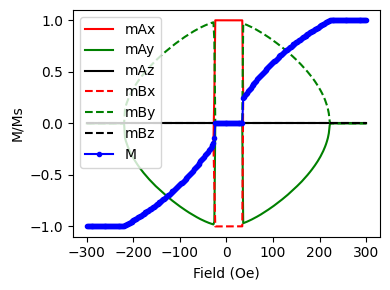

In [5]:
# Plot MxH

plt.close('MxH')
fig = plt.figure('MxH', (4, 3))

# mA
Mx, My, Mz = m_eqs[:, 0, :].T
plt.plot(Hs, Mx,  'r-')
plt.plot(Hs, My,  'g-')
plt.plot(Hs, Mz,  'k-')

# mB
Mx, My, Mz = m_eqs[:, 1, :].T
plt.plot(Hs, Mx,  'r--')
plt.plot(Hs, My,  'g--')
plt.plot(Hs, Mz,  'k--')

# Mean magnetization
Mx, My, Mz = m_eqs.mean(axis=1).T
plt.plot(Hs, Mx,  'b.-')


plt.legend(['mAx', 'mAy', 'mAz', 'mBx', 'mBy', 'mBz', 'M'])
plt.xlabel('Field (Oe)')
plt.ylabel('M/Ms')
plt.tight_layout()

In [6]:
# Calcule the eignesolutions

mSize = int(S.m.size*2/3)
eig_vals = np.zeros((len(Hs), mSize), dtype='complex')
eig_vects = np.zeros((len(Hs), mSize, mSize), dtype='complex')
for i, h in enumerate(Hs):
    S.H = h*e.i
    S.m = m_eqs[i].copy()
    dymas.D_operator(S)
    eig_vals[i], eig_vects[i] = np.linalg.eig(S.RDRz)

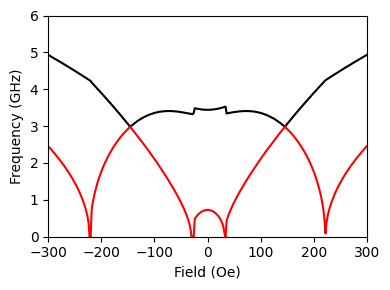

In [7]:
# Plot the ressonance frequencies

plt.close('Fr x H')
plt.figure('Fr x H', (4, 3))

plt.plot(Hs, np.imag(eig_vals[:, 0]/(2*np.pi*1E9)), 'k-')
plt.plot(Hs, np.imag(eig_vals[:, 2]/(2*np.pi*1E9)), 'r-')
plt.plot(Hs, np.imag(eig_vals[:, 1]/(2*np.pi*1E9)), 'k-')
plt.plot(Hs, np.imag(eig_vals[:, 3]/(2*np.pi*1E9)), 'r-')

plt.ylim(0, 6)
plt.xlim(-300, 300)
plt.ylabel('Frequency (GHz)')
plt.xlabel('Field (Oe)')
plt.tight_layout()

In [8]:
# Simulate an FMR experiment
# Calculate an absorption curve at a fixed frequency usign the susceptibility tensor

experiment_freq = 9.8E9  # measurement frequency
experiment_fields = np.linspace(1500, 500, 101)  # measurement fields

# RF field direction
h_rf = [0, 1, 0]

# Oscillating amplitudes
dm = np.zeros((*experiment_fields.shape, 2, 3), dtype='complex')


f = experiment_freq
for i, h in enumerate(experiment_fields):
    S.H = h*e.i
    S.Minimize(target_max_angle=0.5E-3)
    dymas.D_operator(S)

    # Solve the suceptibility tensor
    Chi_Base = np.linalg.inv(2j*np.pi*f*np.eye(4)-S.RDRz)

    # Calculete the Oscillating amplitudes
    RLPh = np.einsum('iau,iab,b->iu', S.R, S.L @ S.P, h_rf).reshape(4)
    dm_v = Chi_Base @ RLPh
    dm[i] = np.einsum('iau,iu->ia', S.R, dm_v.reshape((2, 2)))

# Absorbed power
AbsPower = -np.einsum('hia,a->hi', dm, h_rf).imag.mean(axis=-1)*f

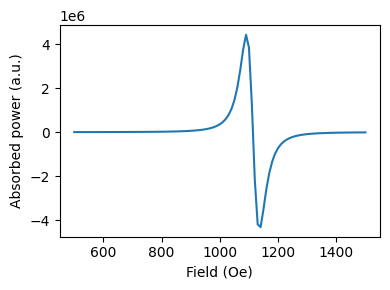

In [9]:
# Plot the field derivative of the absorbed power

plt.close('FMR')
plt.figure('FMR', (4, 3))

field_step = np.diff(experiment_fields)[0]
plt.plot(experiment_fields, np.gradient(AbsPower)/field_step)
plt.xlabel('Field (Oe)')
plt.ylabel('Absorbed power (a.u.)')
plt.tight_layout()